[![Abrir no Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/victorvlle/estate_sales_lakehouse/blob/main/Estate_Sales_Lakehouse.ipynb)

# 📊 Real Estate Sales Analysis 🏡
**Author:** Victor Facundo do Valle  
**Data:** March 2025  
**Technologies:** Python, PySpark, Pandas, Matplotlib   
**Description:** This notebook presents a comprehensive exploratory analysis of real estate sales, leveraging a modern data lakehouse architecture for efficient data management and insights extraction. The dataset undergoes a structured medallion architecture approach—dividing the data into bronze, silver, and gold layers—to ensure high data quality and usability.

## Key Aspects of This Analysis  
✔ **Data Ingestion & Preprocessing** – Collecting and refining raw data while handling inconsistencies, missing values, and duplicates.  
✔ **Data Transformation & Enrichment** – Applying business logic, feature engineering, and optimizing dataset structure.  
✔ **Exploratory Data Analysis (EDA)** – Extracting insights through statistical summaries, trend identification, and correlation analysis.  
✔ **Visualization & Reporting** – Creating interactive and static charts to highlight key real estate patterns and pricing dynamics.  
✔ **Scalability & Performance** – Leveraging **PySpark** for distributed computing, ensuring efficient processing of large-scale datasets.  
✔ **Data Lakehouse Architecture** – Implementing **bronze, silver, and gold layers** to improve **data integrity and analytical readiness**.

---


# *Estate Sales*

Columns Description

* **Serial Number**:  Is just a unique set of digits to identify each transaction.
* **List Year**: This is the year that the particular property was put up for sale.
* **Date Recorded**:  Is the date that the transaction was completed. That is, the year the property was bought.
* **Town**: The town where this property is located.
* **Address**: The property's address.
* **Assessed Value**: How much the property is generally considered to be worth.
* **Sale Amount**: How much the property was actually sold for.
*   **Sales Ratio**: The ratio measures how close the selling price of the property is to it's assessed value.
*   **Property Type**: What kind of property it is.
*   **Residential Type**: If it is a residential property, what type is it.










In [1]:
!pip install pyspark==3.5.0  # Install a compatible Spark version
!pip install delta-spark==2.4.0 # Install the deltalake package

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 4.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.0-py2.py3-none-any.whl size=317425346 sha256=17d70a459a38265755f35d74077de63f24f439c2672ee3478dae30cc656baab7
  Stored in directory: /root/.cache/pip/wheels/38/df/61/8c121f50c3cffd77f8178180dd232d90b3b99d1bd61fb6d6be
Successfully built pyspark
  Attempting uninstall: pyspark
    Found existing installation: pyspark 3.5.5
    Uninstalling pyspark-3.5.5:
      Successfully uninstalled pyspark-3.5.5
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.4/311.4 MB 4.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.4.4-py2.py3-none-any.whl size=311905460 sha256=7ce3196e4da4aafc764cc01cfa8c1fdf3944197b740f582b8cdb5f0bc8916b9f
  Stored in directory: /root/.cache/pip/wheels/6b/0a/a1/2b8f5f192c7df9fdceb8e5a62873d64e46b101f980519bcf55
Successfully built pyspark
  Attempti

## Entity Relationship Diagram

This relational diagram provides a visual representation of the relationships between different entities within a database system. Created using draw.io on a Mac, it serves as a blueprint for understanding the structure and organization of data.

![Diagrama Relacional](https://drive.google.com/uc?id=1Asn-mhuC3xplv-olyaNKGhmPl4vmgg9G)

## Landing

In [2]:
!curl -L -o /content/real-estate-sales-2001-2021-gl.zip https://www.kaggle.com/api/v1/datasets/download/utkarshx27/real-estate-sales-2001-2021-gl
!unzip /content/real-estate-sales-2001-2021-gl.zip


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 35.1M  100 35.1M    0     0  35.9M      0 --:--:-- --:--:-- --:--:-- 35.9M
Archive:  /content/real-estate-sales-2001-2021-gl.zip
  inflating: Real_Estate_Sales_2001-2021_GL.csv  


In [3]:
from pyspark.sql import SparkSession
from delta import *

builder = SparkSession.builder \
    .appName("Delta Lake") \
    .config("spark.sql.extensions", "io.delta.sql.DeltaSparkSessionExtension") \
    .config("spark.sql.catalog.spark_catalog", "org.apache.spark.sql.delta.catalog.DeltaCatalog") \
    .config("spark.jars.packages", "io.delta:delta-core_2.12:2.4.0") \

spark = configure_spark_with_delta_pip(builder).getOrCreate()



## Bronze

In [4]:
schema = 'Serial_Number INT, List_Year INT, Date_Recorded STRING, Town STRING, Address STRING,'\
'Assessed_Value DOUBLE, Sale_Amount DOUBLE, Sales_Ratio DOUBLE, Property_Type STRING,'\
'Residential_Type STRING, Non_Use_Code STRING, Assessor_Remarks STRING, OPM_remarks STRING,'\
'Location STRING'

df_landing = spark.read\
.schema(schema)\
.option('header', 'true')\
.csv('/content/Real_Estate_Sales_2001-2021_GL.csv')

df_landing.write.format('delta').mode('overwrite').save('/content/transaction/bronze/')

In [5]:
df_landing.show(5)

+-------------+---------+-------------+-------+--------------------+--------------+-----------+-----------+-------------+----------------+------------+----------------+-----------+--------------------+
|Serial_Number|List_Year|Date_Recorded|   Town|             Address|Assessed_Value|Sale_Amount|Sales_Ratio|Property_Type|Residential_Type|Non_Use_Code|Assessor_Remarks|OPM_remarks|            Location|
+-------------+---------+-------------+-------+--------------------+--------------+-----------+-----------+-------------+----------------+------------+----------------+-----------+--------------------+
|      2020348|     2020|   09/13/2021|Ansonia|     230 WAKELEE AVE|      150500.0|   325000.0|      0.463|   Commercial|            null|        null|            null|       null|                null|
|        20002|     2020|   10/02/2020|Ashford|     390 TURNPIKE RD|      253000.0|   430000.0|     0.5883|  Residential|   Single Family|        null|            null|       null|            

## Silver

In [6]:
from pyspark.sql.window import Window
from pyspark.sql.functions import col, row_number,to_date, year, dayofmonth, month

def add_surrorgate_key(df, key_order, key_name):
  window = Window.orderBy(col(key_order))
  return df.withColumn(key_name, row_number().over(window))

In [7]:
df_bronze = spark.read.format('delta').load('/content/transaction/bronze/')
df_bronze.show(5)

+-------------+---------+-------------+-------+--------------------+--------------+-----------+-----------+-------------+----------------+------------+----------------+-----------+--------------------+
|Serial_Number|List_Year|Date_Recorded|   Town|             Address|Assessed_Value|Sale_Amount|Sales_Ratio|Property_Type|Residential_Type|Non_Use_Code|Assessor_Remarks|OPM_remarks|            Location|
+-------------+---------+-------------+-------+--------------------+--------------+-----------+-----------+-------------+----------------+------------+----------------+-----------+--------------------+
|      2020348|     2020|   09/13/2021|Ansonia|     230 WAKELEE AVE|      150500.0|   325000.0|      0.463|   Commercial|            null|        null|            null|       null|                null|
|        20002|     2020|   10/02/2020|Ashford|     390 TURNPIKE RD|      253000.0|   430000.0|     0.5883|  Residential|   Single Family|        null|            null|       null|            

In [8]:
from pyspark.sql import functions as f

df_bronze = df_bronze.withColumn("Property_Type",
                                 f.when(f.col("Property_Type") == "Residential", f.regexp_replace(col("Property_Type"), "Residential", col("Residential_Type")))\
                                 .otherwise(col("Property_Type"))
                                 )

df_bronze = df_bronze.withColumn("Address",
                                 f.when(f.col("Address").isNotNull(), f.trim(f.regexp_replace(col("Address"), "^[^a-zA-Z]*\d+[^a-zA-Z]*|[-#]\s*\w+$|UNIT\s*\w+$", "")))\
                                 .otherwise(col("Address"))
                                 )

df_bronze = df_bronze.withColumn("Date_Recorded",
                                 f.when(f.col("Date_Recorded").isNotNull(), f.to_date("Date_Recorded", "MM/dd/yyyy"))
                                 ).filter(f.trim(col("address"))!= "")


In [9]:
df_bronze.show()

+-------------+---------+-------------+----------+-----------------+--------------+-----------+-----------+-------------+----------------+------------------+--------------------+-----------+--------------------+
|Serial_Number|List_Year|Date_Recorded|      Town|          Address|Assessed_Value|Sale_Amount|Sales_Ratio|Property_Type|Residential_Type|      Non_Use_Code|    Assessor_Remarks|OPM_remarks|            Location|
+-------------+---------+-------------+----------+-----------------+--------------+-----------+-----------+-------------+----------------+------------------+--------------------+-----------+--------------------+
|      2020348|     2020|   2021-09-13|   Ansonia|      WAKELEE AVE|      150500.0|   325000.0|      0.463|   Commercial|            null|              null|                null|       null|                null|
|        20002|     2020|   2020-10-02|   Ashford|      TURNPIKE RD|      253000.0|   430000.0|     0.5883|Single Family|   Single Family|              

### Date

In [10]:
date_df = df_bronze.select(f.col("Date_Recorded")).distinct() \
  .withColumnRenamed("Date_Recorded", "full_date")\
  .filter(f.col("full_date").isNotNull())

date_df = date_df.withColumn("day", dayofmonth("full_date"))\
                 .withColumn("month", month("full_date"))\
                 .withColumn("year", year("full_date"))

date_df = add_surrorgate_key(date_df, "full_date", "id_date")

date_df.write.format('delta').mode('overwrite').save('/content/transaction/silver/date/')


In [11]:
date_df.show(5)

+----------+---+-----+----+-------+
| full_date|day|month|year|id_date|
+----------+---+-----+----+-------+
|1999-04-05|  5|    4|1999|      1|
|2001-08-01|  1|    8|2001|      2|
|2001-08-23| 23|    8|2001|      3|
|2001-09-04|  4|    9|2001|      4|
|2001-09-05|  5|    9|2001|      5|
+----------+---+-----+----+-------+
only showing top 5 rows



### Property Type

In [12]:
property_type_df = df_bronze.select("Property_Type").distinct() \
  .withColumnRenamed("Property_Type", "name")\
  .filter(col("name").isNotNull())

property_type_df = add_surrorgate_key(property_type_df, "name", "id_property_type")

property_type_df.write.format('delta').mode('overwrite').save('/content/transaction/silver/property_type/')

In [13]:
property_type_df.show(5)

+-----------+----------------+
|       name|id_property_type|
+-----------+----------------+
| Apartments|               1|
| Commercial|               2|
|      Condo|               3|
|Four Family|               4|
| Industrial|               5|
+-----------+----------------+
only showing top 5 rows



### Town

In [14]:
town_df = df_bronze.select("Town").distinct()\
  .withColumnRenamed("Town", "name")\
  .withColumn("name",f.when(col("name") == "***Unknown***", f.lit(None)).otherwise(col("name")))\
  .filter(col("name").isNotNull())

town_df = add_surrorgate_key(town_df, "name", "id_town")

town_df.write.format('delta').mode('overwrite').save('/content/transaction/silver/town/')

In [15]:
town_df.show(5)

+-----------+-------+
|       name|id_town|
+-----------+-------+
|    Andover|      1|
|    Ansonia|      2|
|    Ashford|      3|
|       Avon|      4|
|Barkhamsted|      5|
+-----------+-------+
only showing top 5 rows



### Address

In [16]:
address_df = df_bronze.select("Address", "Town", "Property_Type").distinct()\
    .withColumnRenamed("Address", "address")

address_df = (address_df
               .join(town_df, address_df['Town'] == town_df['name'], "left")
               .join(property_type_df, address_df['Property_Type'] == property_type_df['name'], "left"))

address_df = address_df.select(
    f.trim(col("address")).alias("name"),
    col("Town").alias("town_name"),
    col("Property_Type").alias("property")
)

address_df = add_surrorgate_key(address_df, "name", "id_address")

address_df.write.format('delta').mode('overwrite').option("mergeSchema", "true").save('/content/transaction/silver/address/')

In [17]:
address_df.show(5)

+--------------------+------------+-------------+----------+
|                name|   town_name|     property|id_address|
+--------------------+------------+-------------+----------+
|"RT 197, PARCEL "...|   Woodstock|         null|         1|
|                  ??|  Burlington|Single Family|         2|
|                  ??|      Canton|        Condo|         3|
|                   A|East Hampton|         null|         4|
|                   A|  Deep River|         null|         5|
+--------------------+------------+-------------+----------+
only showing top 5 rows



### Transaction

In [18]:
transaction_df = df_bronze.select(
    col("Assessed_Value"),
    col("Sale_Amount"),
    col("Sales_Ratio"),
    col("Address"),
    col("Date_Recorded"),
    col("Town"),
    col("Property_Type")
)

transaction_df = (transaction_df.join(address_df,
  (transaction_df["Address"] == address_df["name"]) &
  (transaction_df["Town"] == address_df["town_name"]) &
  (transaction_df["Property_Type"] == address_df["property"]), "left")
.drop("property", "town_name", "name"))

transaction_df = (transaction_df.join(property_type_df, transaction_df["Property_Type"] == property_type_df["name"], "left"))

transaction_df = (transaction_df.join(town_df, transaction_df["Town"] == town_df["name"], "left"))

transaction_df = (transaction_df.join(date_df, transaction_df["Date_Recorded"] == date_df["full_date"], "left"))

transaction_df = transaction_df.select(
    col("id_town"),
    col("id_property_type"),
    col("id_address"),
    col("id_date"),
    col("Assessed_Value"),
    col("Sale_Amount"),
    col("Sales_Ratio")
)

transaction_df = add_surrorgate_key(transaction_df, "id_town", "id_transaction")

transaction_df.write.format('delta').mode('overwrite').save('/content/transaction/silver/transactions/')

## Gold

In [19]:
df_transaction = spark.read.format('delta').load('/content/transaction/silver/transactions/')
df_date = spark.read.format('delta').load('/content/transaction/silver/date/')
df_property_type = spark.read.format('delta').load('/content/transaction/silver/property_type/')
df_address = spark.read.format('delta').load('/content/transaction/silver/address/')
df_town = spark.read.format('delta').load('/content/transaction/silver/town/')

In [20]:
df_transaction.write.format('delta').mode('overwrite').option("mergeSchema", "true").save('/content/transaction/gold/ft_transactions/')
df_date.write.format('delta').mode('overwrite').option("mergeSchema", "true").save('/content/transaction/gold/dm_date/')
df_property_type.write.format('delta').mode('overwrite').option("mergeSchema", "true").save('/content/transaction/gold/dm_property_type/')
df_address.write.format('delta').mode('overwrite').option("mergeSchema", "true").save('/content/transaction/gold/dm_address/')
df_town.write.format('delta').mode('overwrite').option("mergeSchema", "true").save('/content/transaction/gold/dm_town/')

## Metrics

### Dimensions

In [21]:
dm_date = spark.read.format('delta').load('/content/transaction/gold/dm_date/')
dm_date.show(5)

+----------+---+-----+----+-------+
| full_date|day|month|year|id_date|
+----------+---+-----+----+-------+
|1999-04-05|  5|    4|1999|      1|
|2001-08-01|  1|    8|2001|      2|
|2001-08-23| 23|    8|2001|      3|
|2001-09-04|  4|    9|2001|      4|
|2001-09-05|  5|    9|2001|      5|
+----------+---+-----+----+-------+
only showing top 5 rows



In [22]:
dm_town = spark.read.format('delta').load("/content/transaction/gold/dm_town/")
dm_town.show(5)

+-----------+-------+
|       name|id_town|
+-----------+-------+
|    Andover|      1|
|    Ansonia|      2|
|    Ashford|      3|
|       Avon|      4|
|Barkhamsted|      5|
+-----------+-------+
only showing top 5 rows



In [23]:
dm_property_type = spark.read.format('delta').load('/content/transaction/gold/dm_property_type/')
dm_property_type.show(5)

+-----------+----------------+
|       name|id_property_type|
+-----------+----------------+
| Apartments|               1|
| Commercial|               2|
|      Condo|               3|
|Four Family|               4|
| Industrial|               5|
+-----------+----------------+
only showing top 5 rows



In [24]:
dm_address = spark.read.format('delta').load("/content/transaction/gold/dm_address/")
dm_address.show(5)

+--------------------+------------+-------------+----------+
|                name|   town_name|     property|id_address|
+--------------------+------------+-------------+----------+
|"RT 197, PARCEL "...|   Woodstock|         null|         1|
|                  ??|      Canton|        Condo|         2|
|                  ??|  Burlington|Single Family|         3|
|                   A|  Deep River|         null|         4|
|                   A|East Hampton|         null|         5|
+--------------------+------------+-------------+----------+
only showing top 5 rows



In [25]:
ft_transactions = spark.read.format('delta').load("/content/transaction/gold/ft_transactions/")
ft_transactions.show(5)

+-------+----------------+----------+-------+--------------+-----------+-----------+--------------+
|id_town|id_property_type|id_address|id_date|Assessed_Value|Sale_Amount|Sales_Ratio|id_transaction|
+-------+----------------+----------+-------+--------------+-----------+-----------+--------------+
|   null|               7|    134018|   2192|       66540.0|   282450.0|0.235581519|             1|
|      1|               7|      8964|   2390|      109000.0|   170000.0|0.641176471|             2|
|      1|               7|      8964|   4664|      121400.0|   155900.0|0.778704298|             3|
|      1|               7|      8964|   4486|      105300.0|   138000.0|0.763043478|             4|
|      1|               7|     12244|   2781|      164900.0|   244900.0|0.673336056|             5|
+-------+----------------+----------+-------+--------------+-----------+-----------+--------------+
only showing top 5 rows



### Total Properties Bought per Year in Avon City

In [26]:
df_avon = (ft_transactions
 .join(dm_town, ft_transactions["id_town"] == dm_town["id_town"], "inner")
 .join(dm_date, ft_transactions["id_date"] == dm_date["id_date"], "inner")
 .select(dm_town.name, dm_date.year)
 .filter(col("name") == "Avon")
 .groupBy('year').count()
 .orderBy('year'))

df_avon.show(25)

+----+-----+
|year|count|
+----+-----+
|2001|  118|
|2002|  578|
|2003|  505|
|2004|  149|
|2005|  586|
|2006|  450|
|2007|  400|
|2008|  250|
|2009|  118|
|2010|  303|
|2011|  316|
|2012|  365|
|2013|  312|
|2014|  102|
|2015|  410|
|2016|  399|
|2017|  388|
|2018|  308|
|2019|  107|
|2020|  477|
|2021|  504|
|2022|  355|
+----+-----+



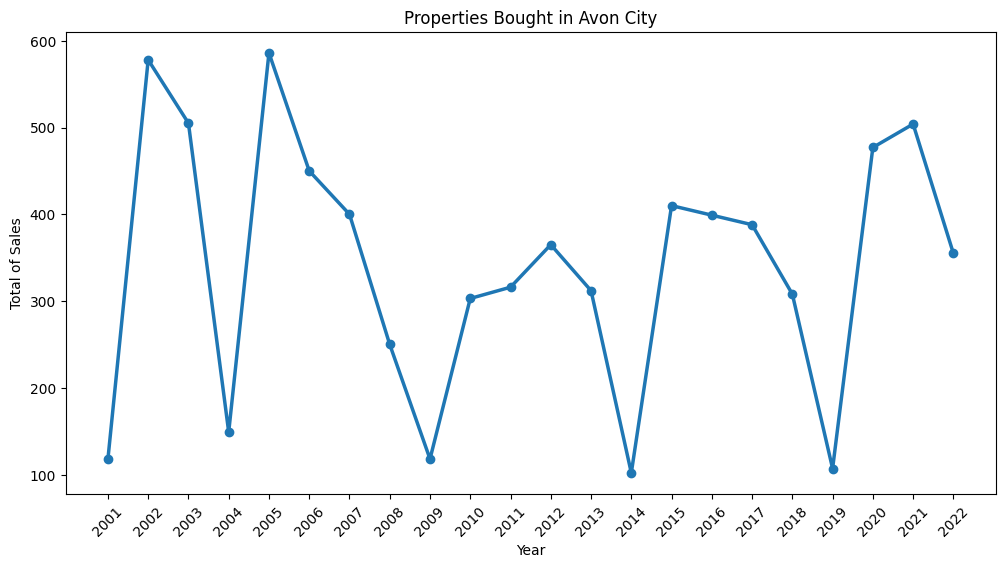

In [27]:
import matplotlib.pyplot as plt
import numpy as np

fig,ax = plt.subplots(figsize = (12,6))
ax.plot(df_avon.toPandas()["year"], df_avon.toPandas()["count"], marker= 'o', linestyle = "-", linewidth=2.5)

ax.set_title("Properties Bought in Avon City")
ax.set_xlabel("Year")
ax.set_ylabel("Total of Sales")

ax.set_xticks(df_avon.toPandas()["year"])
ax.set_xticklabels(df_avon.toPandas()["year"], rotation=45)

plt.show()

### Total of Saled Types on 2019 and 2022

In [28]:
df_prop_type = (ft_transactions
                .join(dm_date, ft_transactions["id_date"] == dm_date["id_date"], "inner")
                .join(dm_property_type, ft_transactions["id_property_type"] == dm_property_type["id_property_type"], "inner")
                .select(dm_date.year, dm_property_type.name)
                .filter(dm_date.year == 2019)
                .groupBy(dm_property_type.name).count())

In [29]:
df_prop_type.show(10)

+-------------+-----+
|         name|count|
+-------------+-----+
|  Four Family|  251|
|   Two Family| 2588|
|Single Family|34888|
|        Condo| 9380|
| Three Family| 1237|
+-------------+-----+



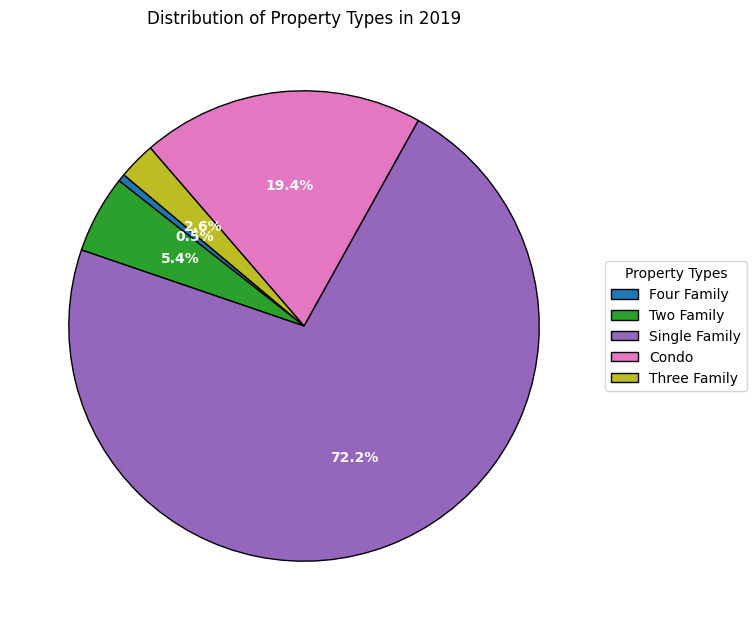

In [30]:
import matplotlib

df_prop_type = df_prop_type.toPandas()

labels = df_prop_type["name"]
sizes = df_prop_type["count"]

cmap = matplotlib.colormaps.get_cmap('tab20')
colors = [cmap(i / len(labels)) for i in range(len(labels))]

plt.style.use('_mpl-gallery-nogrid')

fig, ax = plt.subplots(figsize=(12, 6), subplot_kw=dict(aspect="equal"))
wedges, texts, autotexts = ax.pie(
    sizes, autopct='%1.1f%%', startangle=140,
    textprops={'fontsize': 10}, wedgeprops={'edgecolor': 'black'}, colors=colors
)

plt.setp(autotexts, size=10, weight="bold", color="white")
ax.legend(wedges, labels, title="Property Types", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))

ax.set_title("Distribution of Property Types in 2019")

plt.show()

In [31]:
df_prop_type = (ft_transactions
                .join(dm_date, ft_transactions["id_date"] == dm_date["id_date"], "inner")
                .join(dm_property_type, ft_transactions["id_property_type"] == dm_property_type["id_property_type"], "inner")
                .select(dm_date.year, dm_property_type.name)
                .filter(dm_date.year == 2022)
                .groupBy(dm_property_type.name).count())

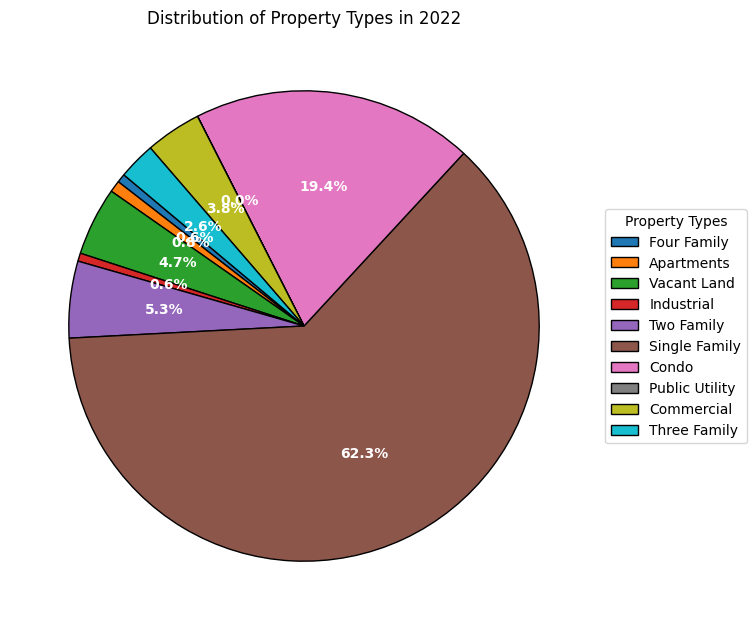

In [32]:
import matplotlib

df_prop_type = df_prop_type.toPandas()

labels = df_prop_type["name"]
sizes = df_prop_type["count"]

cmap = matplotlib.colormaps.get_cmap('tab20')
colors = [cmap(i / len(labels)) for i in range(len(labels))]

plt.style.use('_mpl-gallery-nogrid')

fig, ax = plt.subplots(figsize=(12, 6), subplot_kw=dict(aspect="equal"))
wedges, texts, autotexts = ax.pie(
    sizes, autopct='%1.1f%%', startangle=140,
    textprops={'fontsize': 10}, wedgeprops={'edgecolor': 'black'}, colors=colors
)

plt.setp(autotexts, size=10, weight="bold", color="white")
ax.legend(wedges, labels, title="Property Types", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))

ax.set_title("Distribution of Property Types in 2022")

plt.show()

### Avarage Sales Values in 2019

In [33]:
ft_transactions.show(2)

+-------+----------------+----------+-------+--------------+-----------+-----------+--------------+
|id_town|id_property_type|id_address|id_date|Assessed_Value|Sale_Amount|Sales_Ratio|id_transaction|
+-------+----------------+----------+-------+--------------+-----------+-----------+--------------+
|   null|               7|    134018|   2192|       66540.0|   282450.0|0.235581519|             1|
|      1|               7|      8964|   2390|      109000.0|   170000.0|0.641176471|             2|
+-------+----------------+----------+-------+--------------+-----------+-----------+--------------+
only showing top 2 rows



In [34]:
df_avg_sales = (ft_transactions
                .join(dm_property_type, dm_property_type["id_property_type"] == ft_transactions["id_property_type"], "inner")
                .join(dm_town, dm_town["id_town"] == ft_transactions["id_town"], "inner")
                .join(dm_date, dm_date["id_date"] == ft_transactions["id_date"])
                .filter((dm_property_type.name == "Condo") & (dm_date.year == 2019))
                .groupBy(dm_town.name)
                .agg(f.round(f.avg(col("Sale_Amount")), 2).alias("avg_values")))

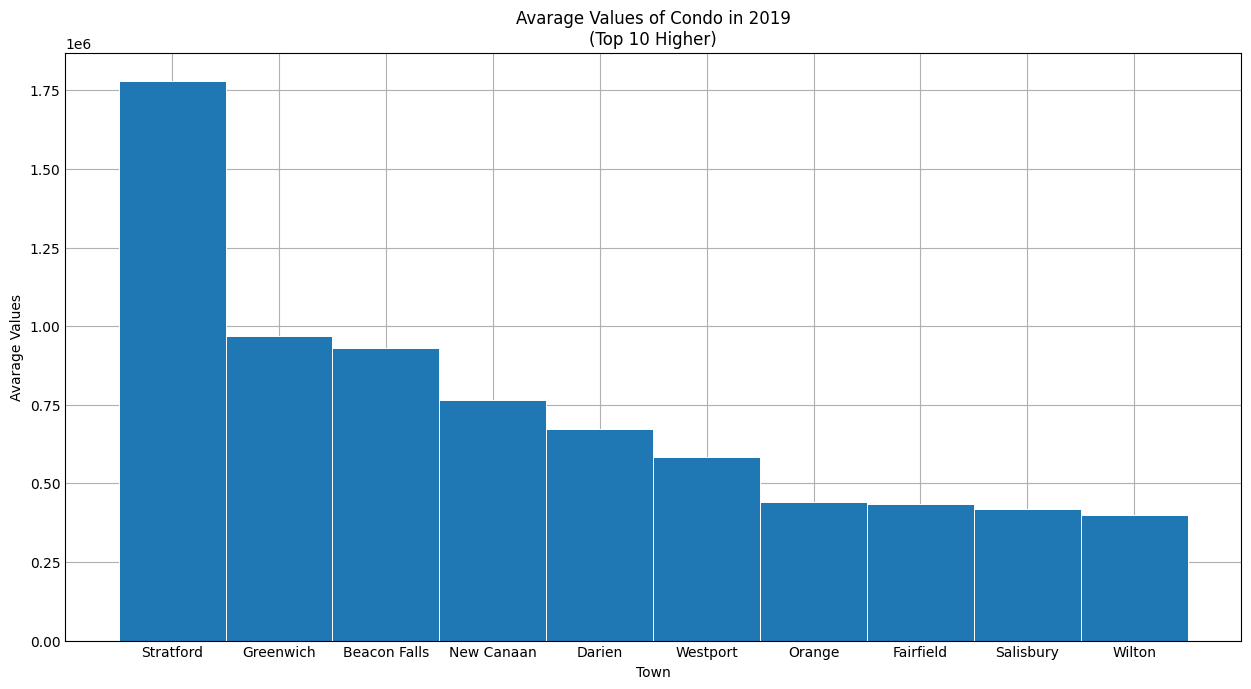

In [35]:
import matplotlib

df_avg_higher = df_avg_sales.orderBy("avg_values", ascending = False).limit(10)

plt.style.use('_mpl-gallery')

fig, ax = plt.subplots(figsize=(12,6))
ax.bar(df_avg_higher.toPandas()['name'], df_avg_higher.toPandas()['avg_values'],  width=1, edgecolor="white", linewidth=0.7)

ax.set_title("Avarage Values of Condo in 2019\n(Top 10 Higher)")
ax.set_xlabel("Town")
ax.set_ylabel("Avarage Values")
ax.set_xlim(auto = True)
ax.set_ylim(auto = True)

plt.show()

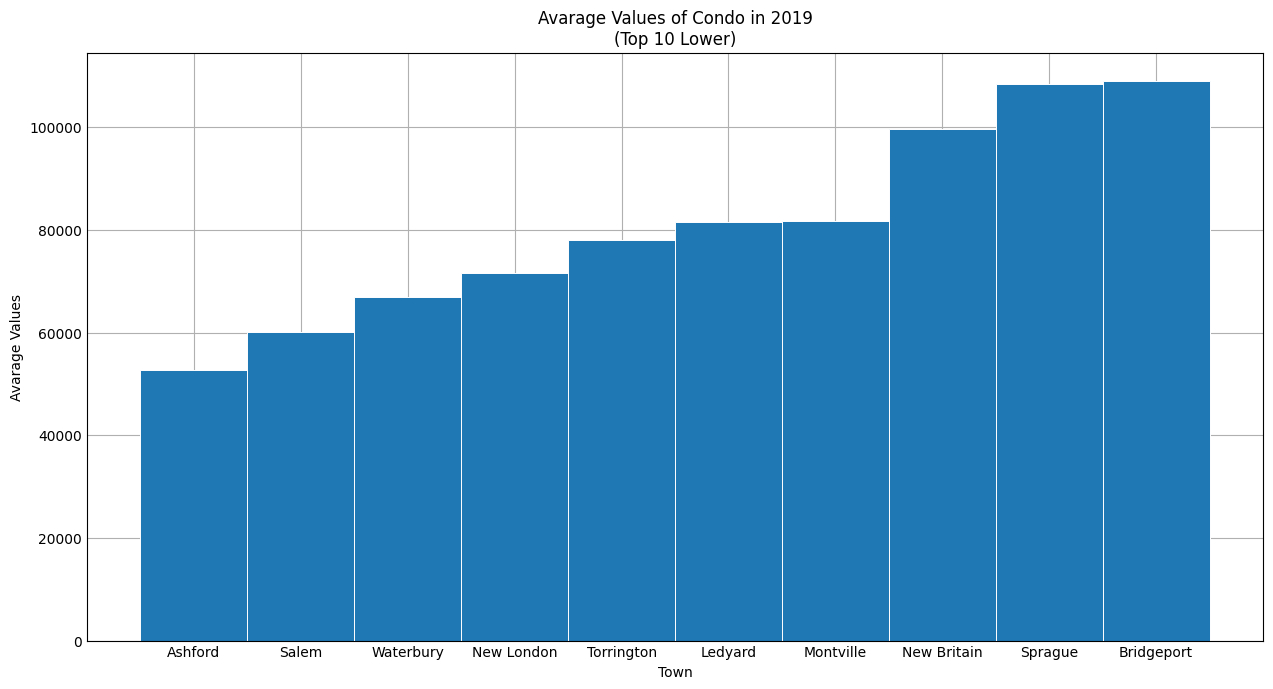

In [36]:
df_avg_lower = df_avg_sales.orderBy("avg_values", ascending = True).limit(10)

plt.style.use('_mpl-gallery')

fig, ax = plt.subplots(figsize=(12,6))
ax.bar(df_avg_lower.toPandas()['name'], df_avg_lower.toPandas()['avg_values'],  width=1, edgecolor="white", linewidth=0.7)

ax.set_title("Avarage Values of Condo in 2019\n(Top 10 Lower)")
ax.set_xlabel("Town")
ax.set_ylabel("Avarage Values")
ax.set_xlim(auto = True)
ax.set_ylim(auto = True)

plt.show()